In [ ]:
!pip install yfinance
import yfinance as yf
import pandas as pd

In [ ]:
sp500 = yf.Ticker("^GSPC")
sp500 = sp500.history(period="max")
sp500

In [ ]:
sp500.index

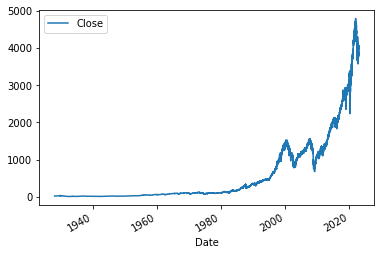

In [9]:
sp500.plot.line(y="Close", use_index=True)

In [10]:
del sp500["Dividends"]
del sp500["Stock Splits"]

In [ ]:
#make tomorrow column
sp500["Tomorrow"] = sp500["Close"].shift(-1)
sp500

In [ ]:
#target for ML
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)
sp500

In [ ]:
#remove data before 1990
sp500 = sp500.loc["1990-01-01":].copy()
sp500

In [18]:
#train model
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)
train = sp500.iloc[:-100]
test = sp500.iloc[-100:]

predictors = ["Close","Volume","Open","High","Low"]
model.fit(train[predictors],train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [20]:
#measure how accurate model is
#how accurate is when market(target) go up data go up too
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])

In [ ]:
preds = pd.Series(preds, index=test.index)

In [33]:
#how accurate it is
precision_score(test["Target"],preds)

0.3472222222222222

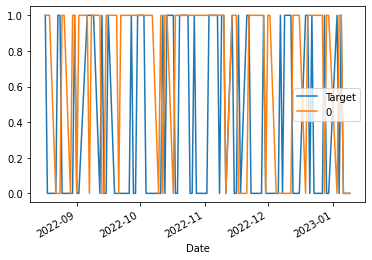

In [34]:
#see how accurate in graph
combined = pd.concat([test["Target"], preds], axis=1)
combined.plot()

In [39]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [40]:
#train first model with first 10year for 11 and so on
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

In [37]:
predictions = backtest(sp500, model, predictors)

In [41]:
#see how many time model predict go up and now
predictions["Predictions"].value_counts()

0    3389
1    2431
Name: Predictions, dtype: int64

In [42]:
#how accurate now
precision_score(predictions["Target"], predictions["Predictions"])


0.5277663512957631

In [43]:
#how many % up or down
predictions["Target"].value_counts() / predictions.shape[0]

1    0.533849
0    0.466151
Name: Target, dtype: float64

In [47]:
#calculate the mean close price in 2days 5 days 60 days 250 days 1000days
#and find ratio bettween today closing price and these periods
horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = sp500.rolling(horizon).mean()

    ratio_column = f"Close_Ratio_{horizon}"
    sp500[ratio_column] = sp500["Close"] / rolling_averages["Close"]

    trend_column = f"Trend_{horizon}"
    sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()["Target"]

    new_predictors += [ratio_column, trend_column]
    

In [ ]:
sp500

In [49]:
sp500 = sp500.dropna()

In [50]:
#new model
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [51]:
#return probability
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >= .6] = 1
    preds[preds < .6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [52]:
predictions = backtest(sp500, model, new_predictors)

In [53]:
predictions["Predictions"].value_counts()

0.0    4006
1.0     813
Name: Predictions, dtype: int64

In [54]:
#accuracy
precision_score(predictions["Target"], predictions["Predictions"])

0.5694956949569495

In [ ]:
#Last note it can be a lot more accurate